<a href="https://colab.research.google.com/github/racoope70/daytrading-with-ml/blob/main/multi_stock_kmeans_trading_strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Protocol Buffer Fix (for TensorFlow)
!pip install --upgrade protobuf
!pip install protobuf==3.20.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.2/316.2 kB 8.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-aiplatform 1.87.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0,>=3.20.2, but you have protobuf 6.30.2 which is incompatible.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 6.30.2 which is incompatible.
tensorflow 2.18.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.3, but you have protobuf 6.30.2 which is incompatible.
tensorflow-metadata 1.16.1 requires protobuf<6.0.0dev,>=4.25.2; python_version >= "3.11", but you have protobuf 6.30.2 which is incompatible.


In [2]:
# Install TensorFlow (latest stable GPU-compatible version)
!pip install tensorflow

# Install Stable Baselines3 and Trading Libraries
!pip install stable-baselines3[extra] gymnasium gym-anytrading yfinance xgboost joblib

# Reinstall RAPIDS dependencies if needed (optional reset)
!pip install --upgrade --force-reinstall \
    dask==2024.11.2 \
    rapids-dask-dependency==24.12.0 \
    cudf-cu12==24.12.0 \
    cuml-cu12==24.12.0 \
    pylibraft-cu12==24.12.0 \
    pylibcudf-cu12==24.12.0 \
    numba==0.61.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.2/172.2 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 16.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-

In [ ]:
import torch
import cudf
import cuml
import dask
import pandas as pd
import numpy as np
import scipy
import lightgbm as lgb
import gymnasium as gym
import stable_baselines3

# Version Checks
print("Library Versions")
print("--------------------")
print("PyTorch:", torch.__version__)
print("CUDA:", torch.version.cuda)
print("cuDF:", cudf.__version__)
print("cuML:", cuml.__version__)
print("Dask:", dask.__version__)
print("Pandas:", pd.__version__)
print("NumPy:", np.__version__)
print("SciPy:", scipy.__version__)
print("LightGBM:", lgb.__version__)
print("Gymnasium:", gym.__version__)
print("Stable Baselines3:", stable_baselines3.__version__)

# GPU Check (Torch + NVIDIA)
print("\nGPU Availability")
print("--------------------")
print("PyTorch GPU Available:", torch.cuda.is_available())
print("GPU Count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))


In [2]:
# System & Utility Libraries
import os
import gc
import json
import pickle
import sys
import time
from datetime import datetime
from collections import defaultdict, deque

# Core Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numba
import IPython.display as display

# Financial Data
import yfinance as yf

# RAPIDS for GPU Acceleration
import cudf
import cupy as cp
from cuml.cluster import KMeans as cuKMeans

# Machine Learning
import joblib
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, f1_score
)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE

# Deep Learning (TensorFlow / Keras)
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Reinforcement Learning (Stable Baselines3)
import stable_baselines3
from stable_baselines3 import A2C, DDPG, DQN, PPO, SAC, TD3
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.logger import configure
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.evaluation import evaluate_policy

# Gym Environments
import gym
import gymnasium as gym
from gym.spaces import Box
from gymnasium.spaces import Box as GymBox, Discrete
from gymnasium.wrappers import TimeLimit
import gym_anytrading
from gym_anytrading.envs import StocksEnv

# Misc Setup
# Set CUDA paths
os.environ['CUDA_HOME'] = '/usr/local/cuda-11.8'
os.environ['PATH'] += ':/usr/local/cuda-11.8/bin'
os.environ['LD_LIBRARY_PATH'] += ':/usr/local/cuda-11.8/lib64'


In [3]:
# Set CUDA Paths (Ensuring GPU Utilization)
os.environ['CUDA_HOME'] = '/usr/local/cuda-11.8'
os.environ['PATH'] += ':/usr/local/cuda-11.8/bin'
os.environ['LD_LIBRARY_PATH'] += ':/usr/local/cuda-11.8/lib64'

In [4]:
!nvidia-smi

Sun Apr  6 09:00:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [9]:
# Utility Functions
def fix_dataframe_index(df):
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    return df.loc[:, ~df.columns.duplicated()]

def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / (loss + 1e-6)
    return 100 - (100 / (1 + rs))

def compute_technical_indicators(df):
    df = fix_dataframe_index(df)
    df['RSI'] = calculate_rsi(df['Close'])
    df['MACD'] = df['Close'].ewm(span=12).mean() - df['Close'].ewm(span=26).mean()
    df['Signal_Line'] = df['MACD'].ewm(span=9).mean()
    df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
    df.dropna(inplace=True)
    return df

def assign_signals_by_forward_return(df_clustered, lookahead=10):
    df_clustered['Future_Close'] = df_clustered['Close'].shift(-lookahead)
    df_clustered['Forward_Return'] = (df_clustered['Future_Close'] - df_clustered['Close']) / df_clustered['Close']
    cluster_returns = df_clustered.groupby('cluster')['Forward_Return'].mean()
    sorted_clusters = cluster_returns.sort_values(ascending=False).index.tolist()
    signal_map = {sorted_clusters[0]: 'Buy', sorted_clusters[1]: 'Hold', sorted_clusters[2]: 'Sell'}
    df_clustered['signal'] = df_clustered['cluster'].map(signal_map)
    return df_clustered, signal_map

def run_kmeans_clustering(df, n_clusters=3, visualize=False):
    features = ['RSI', 'MACD', 'OBV']
    df_selected = df.dropna(subset=features).copy()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_selected[features])
    X_cudf = cudf.DataFrame.from_records(X_scaled)
    kmeans = cuKMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_cudf)
    df_selected['cluster'] = cluster_labels.to_pandas().values
    if visualize:
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_scaled)
        plt.figure(figsize=(8, 6))
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_selected['cluster'], cmap='viridis', s=10)
        plt.title("K-Means Clusters")
        plt.xlabel("PCA Component 1")
        plt.ylabel("PCA Component 2")
        plt.colorbar(label='Cluster')
        plt.tight_layout()
        plt.show()
    return df_selected[['cluster']], df_selected.index

def simulate_trading(df):
    balance = 100000
    position = 0
    portfolio_values = []
    for i in range(len(df)):
        price = df.iloc[i]['Close']
        signal = df.iloc[i].get('signal', 'Hold')
        if signal == 'Buy' and balance > 0:
            position = balance / price
            balance = 0
        elif signal == 'Sell' and position > 0:
            balance = position * price
            position = 0
        portfolio_values.append(balance if balance > 0 else position * price)
    return portfolio_values, portfolio_values[-1]

def evaluate_performance(portfolio_values, market_start, market_end):
    strat_return = (portfolio_values[-1] / portfolio_values[0] - 1) * 100
    market_return = (market_end / market_start - 1) * 100
    sharpe = (np.mean(np.diff(portfolio_values)) / np.std(np.diff(portfolio_values))) * np.sqrt(252) if np.std(np.diff(portfolio_values)) > 0 else 0
    drawdown = max(1 - np.array(portfolio_values) / np.maximum.accumulate(portfolio_values))
    return strat_return, market_return, sharpe, drawdown

def process_stock(ticker, lookahead=10):
    print(f"Processing {ticker}...")
    try:
        df = yf.download(ticker, period="720d", interval="1h")
        if df.empty:
            print(f"No data for {ticker}")
            return None, None
        df.reset_index(inplace=True)
        df = compute_technical_indicators(df)
        cluster_info, cluster_idx = run_kmeans_clustering(df)
        df.loc[cluster_idx, 'cluster'] = cluster_info['cluster']
        df, signal_map = assign_signals_by_forward_return(df, lookahead=lookahead)
        df['Ticker'] = ticker

        portfolio_values, _ = simulate_trading(df)
        strat_ret, mkt_ret, sharpe, drawdown = evaluate_performance(
            portfolio_values, df['Close'].iloc[0], df['Close'].iloc[-1]
        )
        summary = {
            'Ticker': ticker,
            'Strategy Return (%)': strat_ret,
            'Market Return (%)': mkt_ret,
            'Sharpe Ratio': sharpe,
            'Max Drawdown': drawdown
        }

        return df, summary

    except Exception as e:
        print(f"Failed on {ticker}: {e}")
        return None, None

def process_multiple_stocks(tickers):
    all_results = []
    performance_summaries = []
    for ticker in tickers:
        df_result, summary = process_stock(ticker)
        if df_result is not None:
            all_results.append(df_result)
            performance_summaries.append(summary)

    if all_results:
        combined_df = pd.concat(all_results, ignore_index=True)
        combined_df.to_csv("multi_stock_clustered_signals.csv", index=False)
        print("Saved all signals to 'multi_stock_clustered_signals.csv'")

        summary_df = pd.DataFrame(performance_summaries)
        summary_df.sort_values(by='Sharpe Ratio', ascending=False, inplace=True)
        summary_df.to_csv("multi_stock_performance_summary.csv", index=False)
        print("Saved performance summary to 'multi_stock_performance_summary.csv'")
        print(summary_df.head(10))  # Print Top 10 Sharpe performers
    else:
        print("No data processed.")

# Ticker List
ticker_list = ["AAPL", "TSLA", "MSFT", "GOOG", "AMZN", "NVDA", "META", "JPM", "BAC", "WMT",
               "UNH", "V", "PG", "HD", "MA", "DIS", "PEP", "KO", "CSCO", "ADBE", "CRM", "NFLX",
               "PFE", "MRK", "T", "ORCL", "ABBV", "CVX", "XOM", "ABT", "COST", "QCOM", "INTC",
               "MCD", "NKE", "DHR", "LLY", "MDT", "TMO", "TXN", "PM", "AVGO", "NEE", "ACN", "UPS",
               "HON", "LIN", "GS", "IBM"]

process_multiple_stocks(ticker_list)


Processing AAPL...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Processing TSLA...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Processing MSFT...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Processing GOOG...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Processing AMZN...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Processing NVDA...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Processing META...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Processing JPM...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Processing BAC...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Processing WMT...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Processing UNH...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Processing V...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Processing PG...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Processing HD...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Processing MA...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Processing DIS...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Processing PEP...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Processing KO...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Processing CSCO...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Processing ADBE...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Processing CRM...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Processing NFLX...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Processing PFE...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Processing MRK...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Processing T...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Processing ORCL...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Processing ABBV...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Processing CVX...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Processing XOM...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Processing ABT...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Processing COST...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Processing QCOM...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Processing INTC...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Processing MCD...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Processing NKE...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Processing DHR...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Processing LLY...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Processing MDT...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Processing TMO...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Processing TXN...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Processing PM...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Processing AVGO...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Processing NEE...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Processing ACN...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Processing UPS...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Processing HON...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Processing LIN...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Processing GS...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Processing IBM...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Saved all signals to 'multi_stock_clustered_signals.csv'
Saved performance summary to 'multi_stock_performance_summary.csv'
   Ticker  Strategy Return (%)  Market Return (%)  Sharpe Ratio  Max Drawdown
9     WMT            85.722849         100.732709      0.499824      0.118425
5    NVDA           230.327266         483.410656      0.495800      0.430920
30   COST            91.873863         109.335525      0.476068      0.200559
41   AVGO           299.827162         178.682922      0.449001      0.278967
40     PM            41.746834          41.165992      0.434974      0.106584
3    GOOG            68.952802          39.198319      0.422596      0.174243
1    TSLA           134.630728          14.299812      0.419064      0.383523
36    LLY            77.856457         141.038608      0.403163      0.174452
25   ORCL            65.105297          85.795993      0.384065      0.234900
7     JPM            58.830211          66.321197      0.375843      0.231563


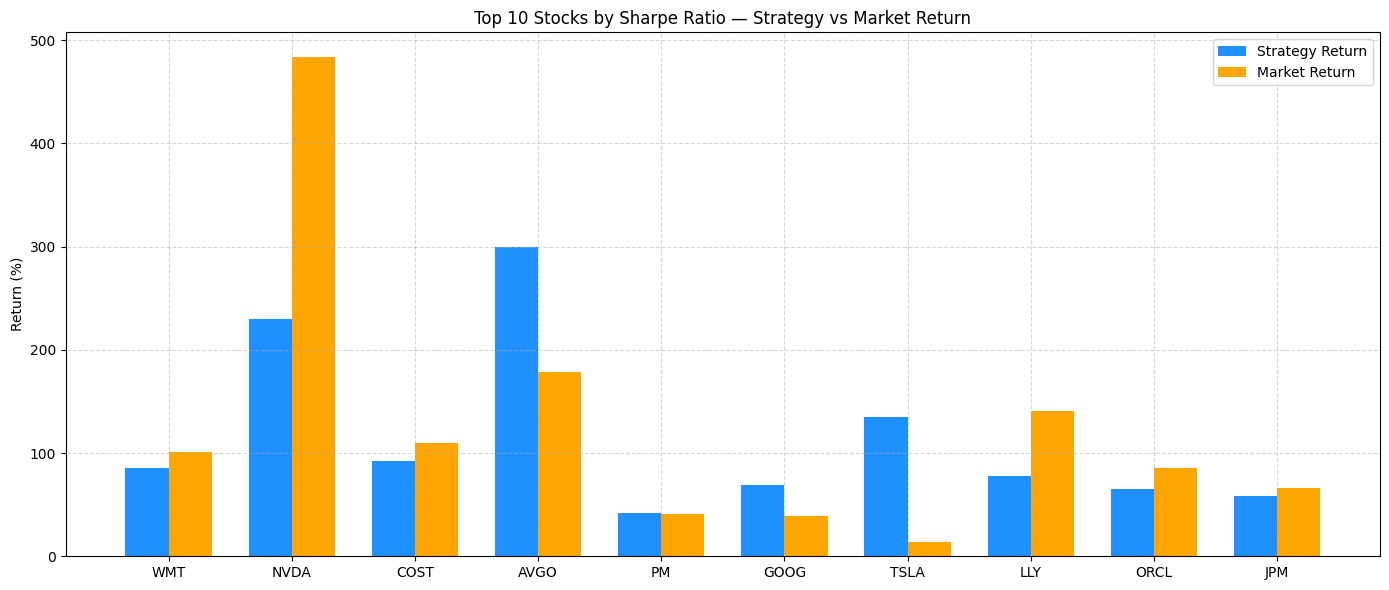

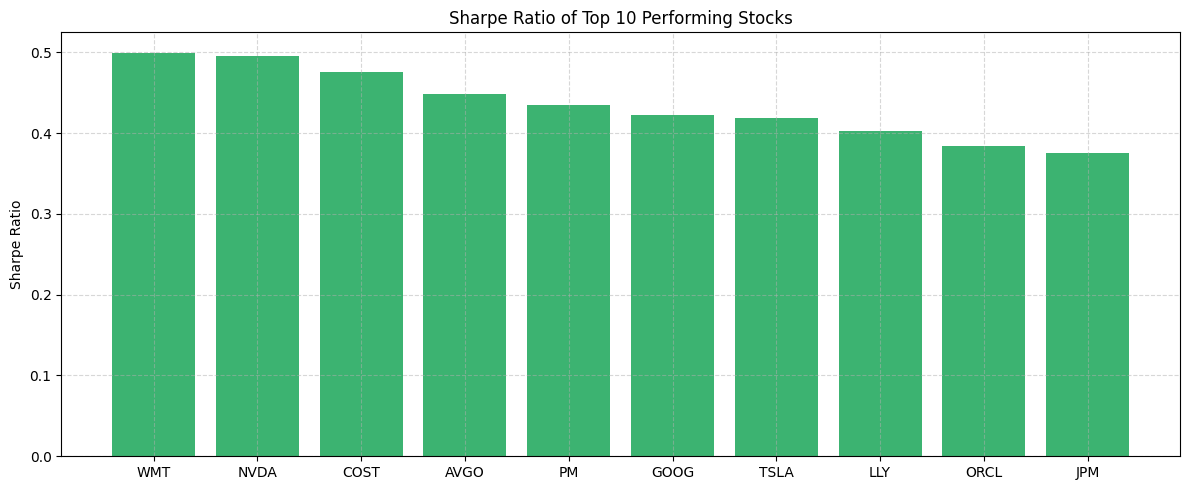

In [10]:
# Load the performance summary
summary_df = pd.read_csv("multi_stock_performance_summary.csv")

# Get Top 10 by Sharpe Ratio
top_10 = summary_df.sort_values(by='Sharpe Ratio', ascending=False).head(10)

# Plot Strategy vs Market Return
plt.figure(figsize=(14, 6))
bar_width = 0.35
x = range(len(top_10))

plt.bar(x, top_10['Strategy Return (%)'], width=bar_width, label='Strategy Return', color='dodgerblue')
plt.bar([i + bar_width for i in x], top_10['Market Return (%)'], width=bar_width, label='Market Return', color='orange')

plt.xticks([i + bar_width / 2 for i in x], top_10['Ticker'])
plt.ylabel("Return (%)")
plt.title("Top 10 Stocks by Sharpe Ratio — Strategy vs Market Return")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Plot Sharpe Ratio
plt.figure(figsize=(12, 5))
plt.bar(top_10['Ticker'], top_10['Sharpe Ratio'], color='mediumseagreen')
plt.title("Sharpe Ratio of Top 10 Performing Stocks")
plt.ylabel("Sharpe Ratio")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
